In [1]:
import os
import gzip
import pickle
import numpy as np
import torch
from urllib.request import urlretrieve
import matplotlib.pyplot as plt
from tqdm import tqdm
from ebm.model import Network
import networkx as nx
from ebm.external_world import ExternalWorld, MNISTExternalWorld

from ebm.train_model import *


def pi(s):
    return torch.clamp(s, 0.0, 1.0)

class ExternalWorld:
    def __init__(self, x_values, y_values):
        self.x = torch.tensor(x_values, dtype=torch.float32)
        self.y = torch.tensor(y_values, dtype=torch.int64)
        self.size_dataset = len(self.x)



In [2]:
import torch.nn as nn
# XOR dataset
xor_x = np.array([[0, 0], [0, 1], [1, 0], [1, 1]], dtype=np.float32)
xor_y = np.array([0, 1, 1, 0], dtype=np.int64)

# ExternalWorld instance with XOR data
xor_world = ExternalWorld(xor_x, xor_y)


In [3]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from matplotlib import cm, colors
from mpl_toolkits.mplot3d import Axes3D


def compute_layout_2d(layer_sizes, x_gap=3.0, y_gap=2.0):
    pos2d = {}
    for i, size in enumerate(layer_sizes):
        offset = (size - 1) * y_gap / 2
        for j in range(size):
            jitter = 0.3 if j % 2 == 0 else -0.3
            pos2d[(i, j)] = (i * x_gap, -j * y_gap + offset + jitter)
    return pos2d


def compute_node_energies(net, sample_idx):
    activations = [layer[sample_idx] for layer in net.layers]
    biases = net.biases
    weights = net.weights
    node_energy = {}

    for i in range(len(activations)):
        for j in range(len(activations[i])):
            a = activations[i][j].item()
            b = biases[i][j].item()
            node_energy[(i, j)] = -b * a if i > 0 else 0.0

    for idx, W in enumerate(weights):
        a_src = activations[idx]
        a_tgt = activations[idx + 1]
        for i in range(W.shape[0]):
            for j in range(W.shape[1]):
                contrib = -a_src[i].item() * W[i, j].item() * a_tgt[j].item()
                node_energy[(idx, i)] += 0.5 * contrib
                node_energy[(idx + 1, j)] += 0.5 * contrib

    return node_energy


In [4]:
def build_energy_graph(net, sample_idx):
    G = nx.DiGraph()
    activations = [layer[sample_idx] for layer in net.layers]
    particles = [p[sample_idx] for p in net.persistent_particles]
    y = net.y_data[sample_idx].item()
    node_energy = compute_node_energies(net, sample_idx)

    layer_sizes = [net.weights[0].shape[0]] + [w.shape[1] for w in net.weights]
    layer_labels = ['Input'] + [f'Hidden {i+1}' for i in range(len(net.hyperparameters["hidden_sizes"]))] + ['Output']

    for i, size in enumerate(layer_sizes):
        for j in range(size):
            act = activations[i][j].item()
            bias = net.biases[i][j].item()
            post = act + bias if i > 0 else act
            particle = particles[i - 1][j].item() if i > 0 else 0.0
            output_val = act if i == len(layer_sizes) - 1 else None

            label = f"{layer_labels[i]} {j}\n"
            label += f"Pre = {act:.2f}  Bias = {bias:.2f}\nPost = {post:.2f}"
            if output_val is not None:
                label += f"\nŷ = {output_val:.2f}  y = {y}"

            G.add_node((i, j),
                       label=label,
                       activation=act,
                       bias=bias,
                       particle=particle,
                       energy=node_energy[(i, j)],
                       layer=i)

    for idx, W in enumerate(net.weights):
        a_src = activations[idx]
        a_tgt = activations[idx + 1]
        for i in range(W.shape[0]):
            for j in range(W.shape[1]):
                w = W[i, j].item()
                contrib = -a_src[i].item() * w * a_tgt[j].item()
                G.add_edge((idx, i), (idx + 1, j),
                           weight=w,
                           contrib=contrib,
                           label=f"{w:.2f}\nΔE={contrib:.2f}")
    return G, layer_sizes


In [33]:
def draw_energy_graph_3d(net, sample_idx, x_gap=10.0, y_gap=2.0):
    import matplotlib.pyplot as plt
    import matplotlib.colors as mcolors
    import matplotlib.cm as cm
    import numpy as np
    from mpl_toolkits.mplot3d import Axes3D

    # === Helpers ===
    def get_node_style(i, total_layers):
        if i == 0:
            return {'marker': 's', 'facecolor': 'skyblue'}  # input
        elif i == total_layers - 1:
            return {'marker': '^', 'facecolor': 'salmon'}   # output
        else:
            return {'marker': 'o', 'facecolor': 'lightgray'}  # hidden

    def draw_layer_planes(ax, layer_sizes, pos2d, zmin, zmax, alpha=0.08):
        x_vals = sorted(set(x for (x, y) in pos2d.values()))
        for x in x_vals:
            ax.plot_surface(
                np.array([[x, x], [x, x]]),
                np.array([[-10, 10], [-10, 10]]),
                np.array([[zmin, zmin], [zmax, zmax]]),
                color='gray', alpha=alpha, zorder=-1
            )

    # === Setup ===
    G, layer_sizes = build_energy_graph(net, sample_idx)
    total_layers = len(layer_sizes)
    pos2d = compute_layout_2d(layer_sizes, x_gap, y_gap)
    energies = [G.nodes[n]['energy'] for n in G.nodes()]
    edge_contribs = [G.edges[e]['contrib'] for e in G.edges()]
    norm_node = mcolors.Normalize(vmin=-max(map(abs, energies)), vmax=max(map(abs, energies)))
    norm_edge = mcolors.Normalize(vmin=-max(map(abs, edge_contribs)), vmax=max(map(abs, edge_contribs)))
    cmap_node = cm.RdBu
    cmap_edge = cm.coolwarm

    fig = plt.figure(figsize=(18, 6))
    ax = fig.add_subplot(111, projection='3d')
    fig.patch.set_facecolor('white')
    ax.set_facecolor('white')

    zmin, zmax = min(energies), max(energies)

    # === Layer Background Planes ===
    draw_layer_planes(ax, layer_sizes, pos2d, zmin=zmin - 1, zmax=zmax + 1)

    # === Draw nodes ===
    for (i, j) in G.nodes():
        x, y = pos2d[(i, j)]
        z = G.nodes[(i, j)]['energy']
        p = G.nodes[(i, j)]['particle']
        label = G.nodes[(i, j)]['label']
        particle_color = cm.PuBu((p + 1) / 2)

        style = get_node_style(i, total_layers)

        ax.scatter([x], [y], [z], s=120, marker=style['marker'],
                   color=style['facecolor'], edgecolors='black', alpha=0.9)

        ax.text(x, y, z + 0.4, label, fontsize=7, ha='center', va='bottom',
                bbox=dict(boxstyle='round,pad=0.3', facecolor=particle_color,
                          edgecolor='black', linewidth=0.5, alpha=0.8))

    # === Draw edges ===
    for u, v in G.edges():
        x0, y0 = pos2d[u]
        x1, y1 = pos2d[v]
        z0 = G.nodes[u]['energy'] * 5
        z1 = G.nodes[v]['energy'] * 5
        contrib = G.edges[(u, v)]['contrib']
        label = G.edges[(u, v)]['label']
        color = cmap_edge(norm_edge(contrib))

        ax.plot([x0, x1], [y0, y1], [z0, z1], color=color, linewidth=2, alpha=0.9)
        ax.text((x0+x1)/2, (y0+y1)/2, (z0+z1)/2 + 0.2, label, fontsize=6,
                ha='center', bbox=dict(facecolor=color, edgecolor='none', boxstyle='round,pad=0.2'))

    # === Annotate layers ===
    for i in range(total_layers):
        x = i * x_gap
        ax.text(x, y=0, z=zmax + 1.5, s=f"Layer {i}", ha='center', fontsize=9, weight='bold')

    ax.set_title(f"Sample {sample_idx} | Total Energy = {sum(energies):.4f}")
    ax.set_xlabel("Layer (x)")
    ax.set_ylabel("Position (y)")
    ax.set_zlabel("Energy (z)")
    ax.view_init(elev=20, azim=-60)
    ax.grid(False)
    plt.tight_layout()
    plt.show()


In [34]:
def visualize_all_samples(net):
    for sample_idx in range(len(net.x_data)):
        draw_energy_graph_3d(net, sample_idx)


In [35]:
def train_net(net: Network, plot_graph = False):
    history = {"Energy": [], "Cost": [], "Error": []}
    epochs, batch_size = net.hyperparameters["n_epochs"], net.hyperparameters["batch_size"]
    n_batches = net.dataset_size // batch_size
    n_it_neg, n_it_pos, alphas = net.hyperparameters["n_it_neg"], net.hyperparameters["n_it_pos"], net.hyperparameters["alphas"]


    snapshot_epochs = np.linspace(0, epochs - 1, 2, dtype=int)
    # with tqdm(total=epochs, desc="Training Progress", unit="epoch") as epoch_bar:
    for epoch in range(epochs):
        for i in range(n_batches):
            net.update_mini_batch_index(i)
            net.negative_phase(n_it_neg)
            net.positive_phase(n_it_pos, *alphas)

        # Measure and log
        E, C, error = net.measure()
        history["Energy"].append(E)
        history["Cost"].append(C)
        history["Error"].append(error * 100)

        if(plot_graph):
            if epoch in snapshot_epochs:
            # if(history["Error"][-1]< 0.001):
                plot_network_weights(net, epoch)
                visualize_all_samples(net)
    # Plot results
    res = np.mean(history["Error"][-4:])
    if(plot_graph):
        fig, axes = plt.subplots(1, 3, figsize=(18, 4))
        for ax, (key, color) in zip(axes, [("Energy", "blue"), ("Cost", "orange"), ("Error", "red")]):
            ax.plot(history[key], label=key, color=color)
            ax.set_title(f"{key} over Epochs")
        plt.tight_layout()
        plt.show()
    return res

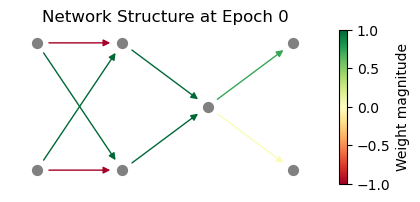

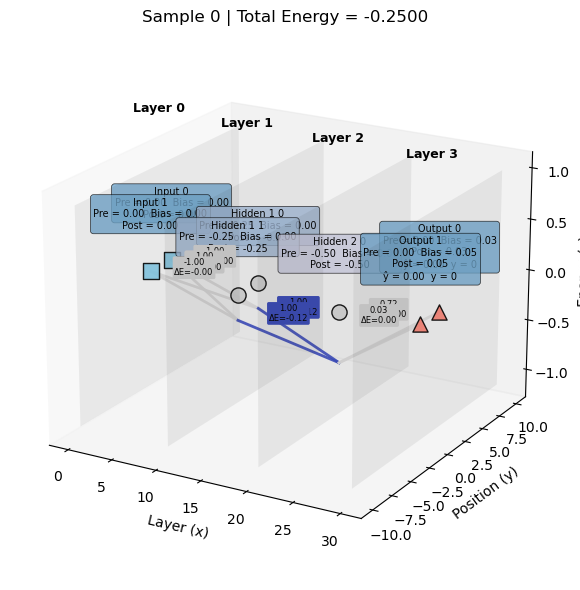

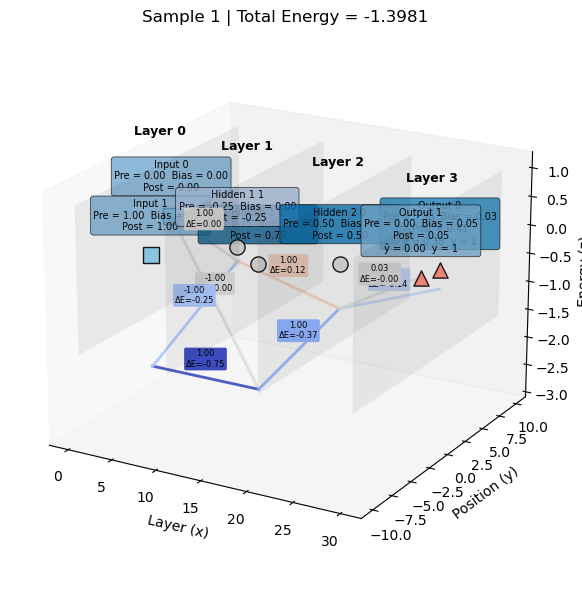

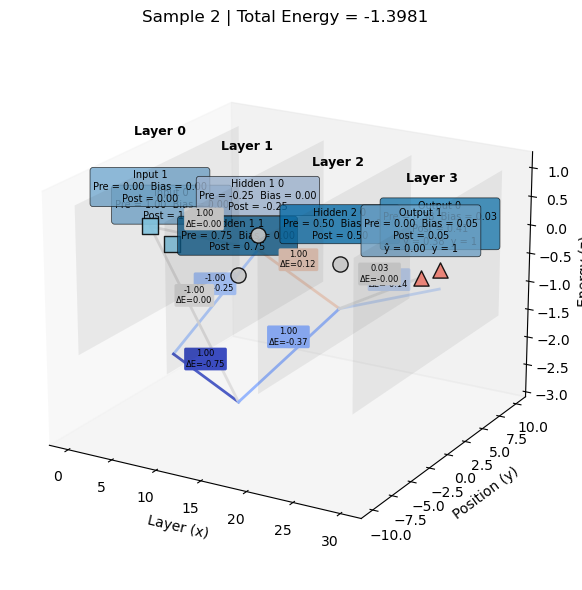

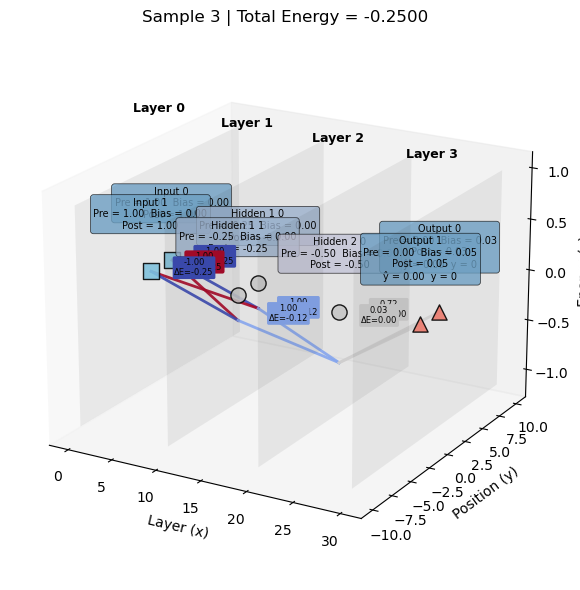

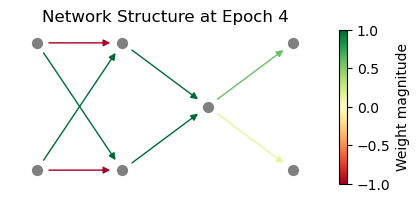

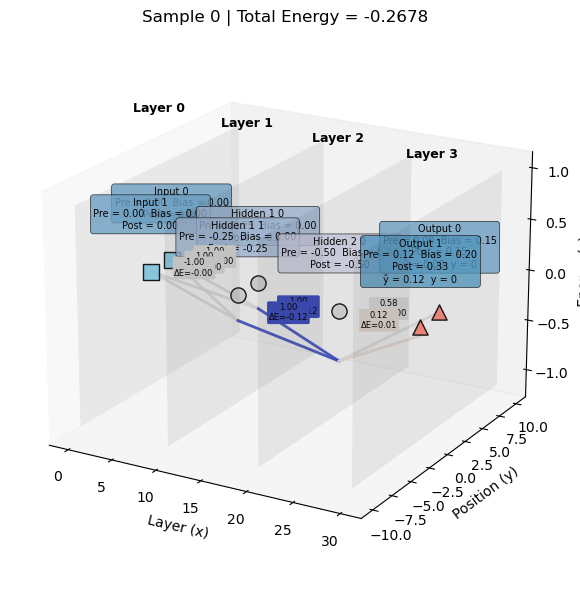

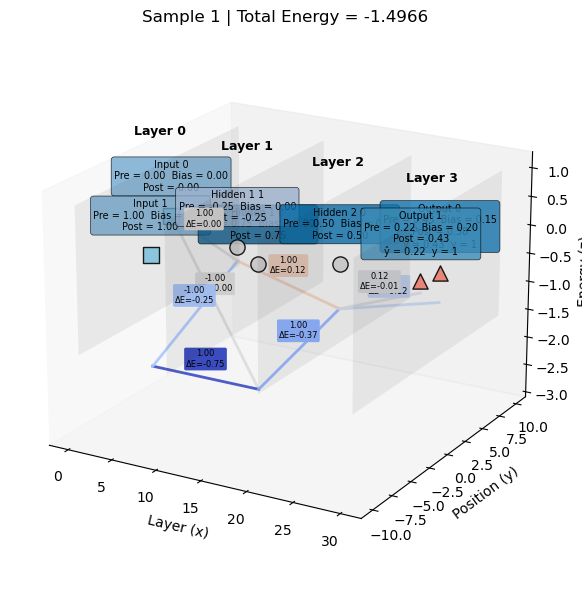

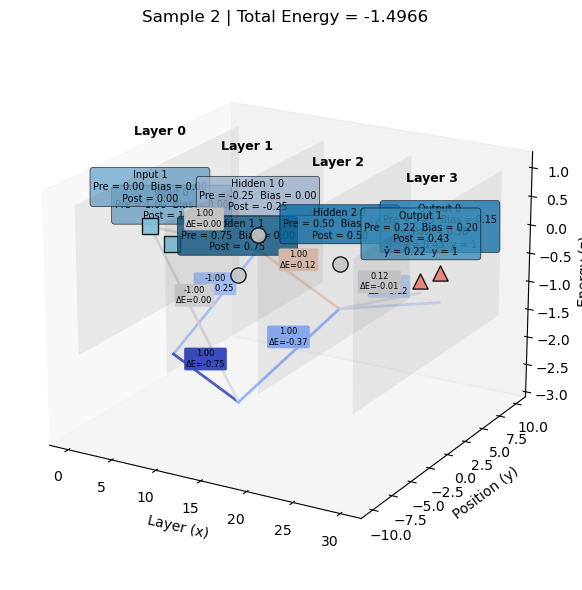

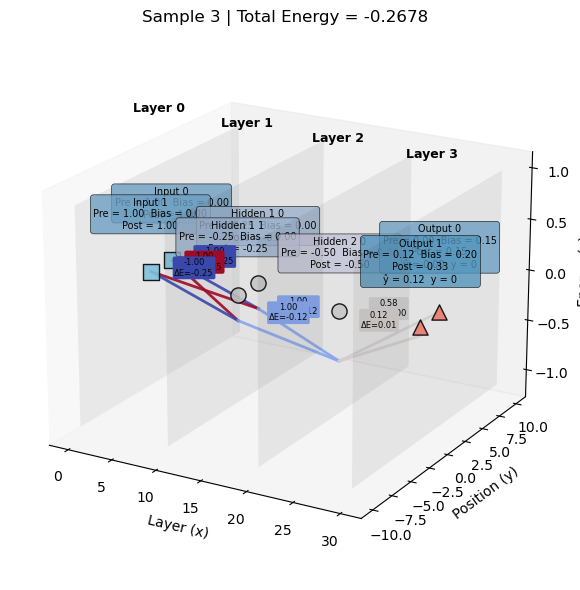

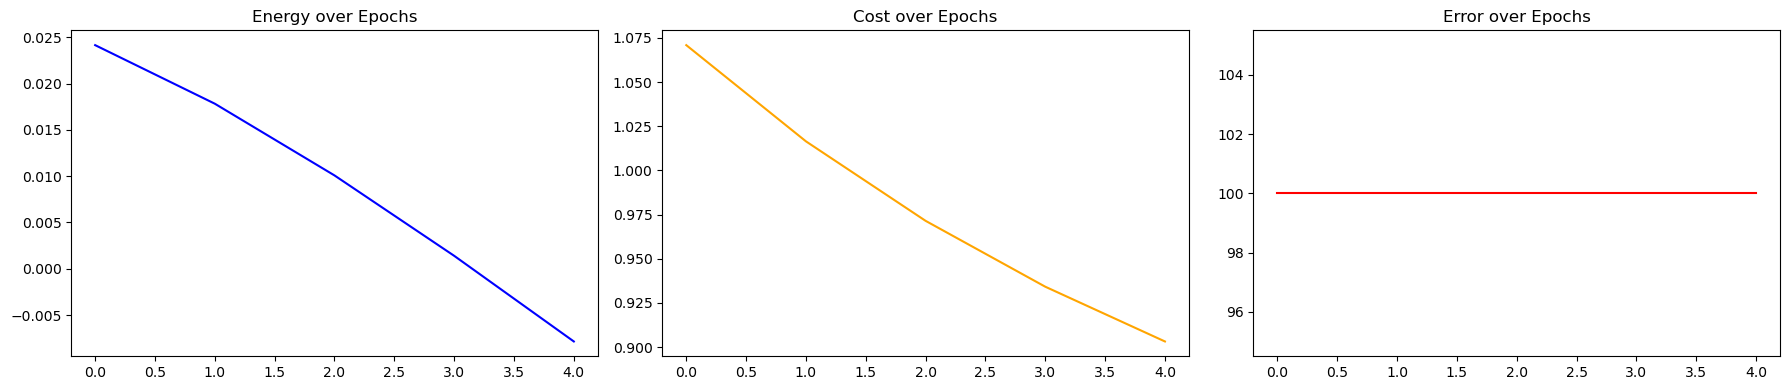

err 100.0
[tensor([[0., 0.],
        [0., 1.],
        [1., 0.],
        [1., 1.]]), tensor([[-0.2500, -0.2500],
        [ 0.7500, -0.2500],
        [-0.2500,  0.7500],
        [-0.2500, -0.2500]]), tensor([[-0.5000],
        [ 0.5000],
        [ 0.5000],
        [-0.5000]]), tensor([[0.0000, 0.1233],
        [0.4285, 0.2206],
        [0.4285, 0.2206],
        [0.0000, 0.1233]])]
[tensor([0., 0.]), tensor([0., 0.]), tensor([0.]), tensor([0.1490, 0.2047])]
[tensor([[-1.,  1.],
        [ 1., -1.]]), tensor([[1.0000],
        [1.0000]]), tensor([[0.5804, 0.1199]])]
[tensor([[-0.2500, -0.2500],
        [ 0.7500, -0.2500],
        [-0.2500,  0.7500],
        [-0.2500, -0.2500]]), tensor([[-0.5000],
        [ 0.5000],
        [ 0.5000],
        [-0.5000]]), tensor([[0.0000, 0.1233],
        [0.4285, 0.2206],
        [0.4285, 0.2206],
        [0.0000, 0.1233]])]


In [36]:
xor_net = Network(
            name=f"xor_trial",
            external_world=xor_world,
            hyperparameters={
                "hidden_sizes": [2, 1],
                "output_size": 2,
                "batch_size": 4,
                "n_epochs": 5,  # just test untrained net
                "n_it_neg": 1,
                "n_it_pos": 1,
                "alphas": [0.1,0.1,0.1],
                             "activation": "relu"
            }
        )

        # Unpack init into weights and biases

init = [-1.   ,      1.   ,      1.    ,    -1.     ,    1.0000024 , 1.0000024]
init = torch.tensor(init, dtype=torch.float32)

with torch.no_grad():
    xor_net.weights[0][:] = init[0:4].reshape(2, 2) #torch.tensor([-1, -0.25, 0.25, 1]).reshape(2, 2)
    xor_net.weights[1][:] = init[4:6].reshape(2, 1)# torch.tensor([-1, 1]).reshape(2, 1)


# Evaluate the net — assume this function exists
print('err', train_net(xor_net, plot_graph= True))
# print("Total layer sum:", sum(l.sum() for l in xor_net.layers).item())
# print("Total weight sum:", sum(w.sum() for w in xor_net.weights).item())
# print("Total bias sum:", sum(b.sum() for b in xor_net.biases).item())

print(xor_net.layers)
print(xor_net.biases)
print(xor_net.weights)
print(xor_net.persistent_particles)




[tensor([[0., 0.],
        [0., 1.],
        [1., 0.],
        [1., 1.]]), tensor([[-0.2500, -0.2500],
        [ 0.7500, -0.2500],
        [-0.2500,  0.7500],
        [-0.2500, -0.2500]]), tensor([[-0.5000],
        [ 0.5000],
        [ 0.5000],
        [-0.5000]]), tensor([[0.5000, 0.0000],
        [0.0000, 0.5000],
        [0.0000, 0.5000],
        [0.5000, 0.0000]])]
[tensor([[-1.0375,  0.0125],
        [ 0.0125, -1.0375]]), tensor([[1.0000],
        [1.0000]]), tensor([[-1.,  1.]])]
[tensor([0., 0.]), tensor([0., 0.]), tensor([0.]), tensor([0., 0.])]
